In [217]:
import sklearn
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import joblib
import pickle
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_selector as selector
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer, CountVectorizer
from sklearn.feature_selection import RFE

import warnings
warnings.filterwarnings('ignore')

def evaluate_model(y_test, y_pred):
    print("Mean absolute error:\t", int(mean_absolute_error(y_test, y_pred)))
    print("Mean squared error:\t", int(mean_squared_error(y_test, y_pred)))

In [218]:
df_raw = pd.read_pickle("./data.pkl")
df_raw

,bouwjaar,kilometer_stand,vermogen,prijs,is_handgeschakeld,is_benzine,upload_datum,apk,titel
1,2008,169504.0,78,2950.0,0.0,1,34,110,fiat grande punto emotion automaat airco
2,2007,219718.0,65,1950.0,1.0,1,29,165,fiat grande punto edizione cool airco cruise
3,2006,199908.0,95,1895.0,1.0,1,29,201,fiat grande punto emotion airco
4,2008,138191.0,65,2740.0,1.0,1,29,363,fiat grande punto active airco rijdt prima
5,2006,139057.0,65,2950.0,1.0,1,29,263,fiat grande punto sportsound airco
...,...,...,...,...,...,...,...,...,...
514,2008,115141.0,65,3699.0,1.0,1,4,171,fiat grande punto dynamic panodak auto
515,2008,151778.0,78,3499.0,1.0,1,4,229,fiat grande punto edizione lusso clima cruise
516,2011,135730.0,84,2350.0,1.0,0,4,220,fiat grande punto actual
517,2007,133073.0,65,3450.0,1.0,1,4,171,fiat grande punto active deurs airco inch


In [219]:
df_train, df_test = train_test_split(df_raw, test_size=0.2, random_state=42)

X_train = df_train.drop(['prijs'], axis=1)
y_train = df_train[['prijs']]

X_test = df_test.drop(['prijs'], axis=1)
y_test = df_test[['prijs']]['prijs']
X_test

,bouwjaar,kilometer_stand,vermogen,is_handgeschakeld,is_benzine,upload_datum,apk,titel
509,2006,179985.0,77,1.0,1,3,343,fiat grande punto edizione prima
35,2008,156995.0,95,1.0,1,30,348,fiat grande punto racing sport versn
146,2007,134163.0,78,0.0,1,35,218,fiat grande punto dynamic automaat distributie
75,2006,214170.0,78,1.0,1,102,262,fiat grande punto blue clima panodk eigen
83,2007,69724.0,78,1.0,1,34,171,fiat grande punto dynamic
...,...,...,...,...,...,...,...,...
155,2009,256290.0,69,1.0,1,35,17,fiat grande punto natural power airco
44,2006,107414.0,65,1.0,1,31,289,fiat grande punto sportsound airco nette auto
272,2008,179987.0,78,1.0,1,46,171,fiat grande punto dynamic airco cruise
417,2006,213182.0,95,1.0,1,17,171,fiat grande punto dynamic bleuline huurkoop inru


In [220]:
pipelines = []
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('LR', DecisionTreeRegressor())])))
pipelines.append(('Lasso                      ', Pipeline([('preprocessor', preprocessor),('LASSO', Lasso())])))
pipelines.append(('ElasticNet                 ', Pipeline([('preprocessor', preprocessor),('EN', ElasticNet())])))
pipelines.append(('KNeighborsRegressor        ', Pipeline([('preprocessor', preprocessor),('KNN', KNeighborsRegressor())])))
pipelines.append(('DecisionTreeRegressor      ', Pipeline([('preprocessor', preprocessor),('CART', DecisionTreeRegressor())])))
pipelines.append(('GradientBoostingRegressor  ', Pipeline([('preprocessor', preprocessor),('GBM', GradientBoostingRegressor())])))
pipelines.append(('RandomForestRegressor      ', Pipeline([('preprocessor', preprocessor),('GBM', RandomForestRegressor(n_estimators=100))])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=21)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_absolute_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %i (%i)" % (name, abs(cv_results.mean()), cv_results.std())
    print(msg)

DecisionTreeRegressor      : 619 (74)
Lasso                      : 448 (56)
ElasticNet                 : 469 (76)
KNeighborsRegressor        : 527 (71)
DecisionTreeRegressor      : 596 (79)
GradientBoostingRegressor  : 437 (66)
RandomForestRegressor      : 461 (59)


In [221]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, ['bouwjaar', "kilometer_stand", "vermogen", "upload_datum", "apk"]),
        ('text',  CountVectorizer(), 'titel')
    ],
    remainder='passthrough')

param_grid = {
#     'preprocessor__numeric__imputer__strategy': ['mean', 'median', 'constant'],
#     'preprocessor__text__ngram_range': [(1,1), (1,2)],
    'classifier__fit_intercept': [True, False],
    'classifier__normalize': [True, False],
    'classifier__tol': np.arange(0, 0.1, 0.01) 
}

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', Lasso())
])

grid_search = GridSearchCV(clf, 
                           param_grid, 
                           cv=3,
                           scoring='neg_mean_absolute_error'
)

grid_search.fit(X_train, y_train)

print(("Best result: %.3f" % abs(grid_search.score(X_test, y_test))))

grid_search.best_params_

Best result: 426.316


{'classifier__fit_intercept': True,
 'classifier__normalize': False,
 'classifier__tol': 0.08}

In [222]:
y_pred = grid_search.best_estimator_.predict(X_test)
evaluate_model(y_test, y_pred)

Mean absolute error:	 426
Mean squared error:	 328136


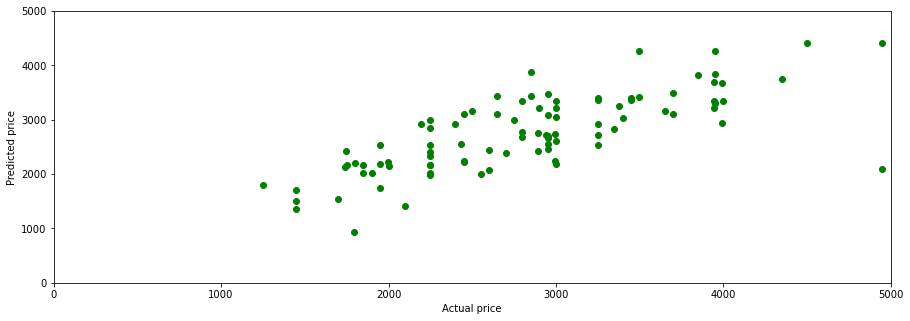

In [216]:
plt.figure(figsize=(15,5))
plt.scatter(y_test,y_pred,c='green')
plt.xlabel('Actual price')
plt.ylabel('Predicted price')
plt.xlim(0, 5000)
plt.ylim(0, 5000)
plt.show()

In [224]:
joblib.dump(grid_search.best_estimator_, 'Regressor')

['Regressor']